In [87]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns



path = "../data/2_cleaned/water_intake_cleaned.csv"
df = pd.read_csv(path)

In [88]:
y = df["Hydration Level"].map({
    "Poor": 0,
    "Good": 1
})

X = df.drop("Hydration Level", axis=1)

target_names=["Poor", "Good"]


In [89]:
categorical_cols = [
    "Gender",
    "Physical Activity Level",
    "Weather"
]

numerical_cols = [
    "Age",
    "Weight",
    "Daily Water Intake"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numerical_cols)
    ]
)

X_processed = preprocessor.fit_transform(X)


In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [91]:
print(f"Train set: {X_train.shape[0]} échantillons")
print(f"Test set: {X_test.shape[0]} échantillons")
print(f"\nDistribution dans le train set: {np.unique(y_train, return_counts=True)[1]}")
print(f"Distribution dans le test set: {np.unique(y_test, return_counts=True)[1]}")

Train set: 21000 échantillons
Test set: 9000 échantillons

Distribution dans le train set: [ 4259 16741]
Distribution dans le test set: [1826 7174]


In [92]:
print(" Entraînement du Random Forest...")
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced",
        max_depth=5,              # 🔑 main control
        min_samples_split=20,
        min_samples_leaf=10,
    ))
])

pipeline.fit(X_train, y_train)


 Entraînement du Random Forest...


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [93]:
# Prédictions
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=["Poor", "Good"]))


Accuracy: 0.8883333333333333
              precision    recall  f1-score   support

        Poor       0.65      0.96      0.78      1826
        Good       0.99      0.87      0.93      7174

    accuracy                           0.89      9000
   macro avg       0.82      0.91      0.85      9000
weighted avg       0.92      0.89      0.90      9000



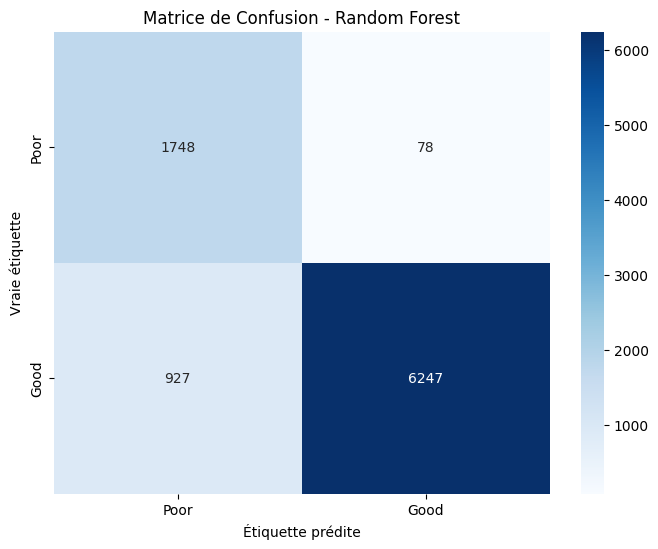

In [94]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de Confusion - Random Forest')
plt.ylabel('Vraie étiquette')
plt.xlabel('Étiquette prédite')
plt.show()

🔍 Importance des features:
                                  feature  importance
10                num__Daily Water Intake    0.263570
6                        cat__Weather_Hot    0.174828
2       cat__Physical Activity Level_High    0.174488
3        cat__Physical Activity Level_Low    0.144811
9                             num__Weight    0.097707
5                       cat__Weather_Cold    0.070334
4   cat__Physical Activity Level_Moderate    0.030892
7                     cat__Weather_Normal    0.023657
8                                num__Age    0.019480
1                        cat__Gender_Male    0.000125
0                      cat__Gender_Female    0.000109


C:\Users\IdeaPad\AppData\Local\Temp\ipykernel_36612\1509497922.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')


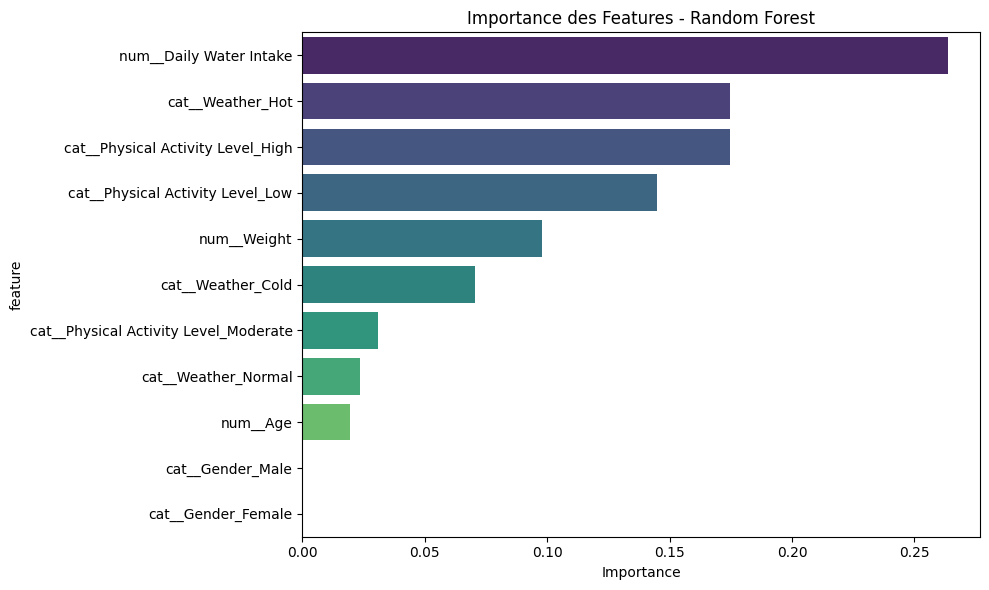

In [95]:
# Importance des features
importances = pipeline.named_steps["model"].feature_importances_
preprocessor = pipeline.named_steps["preprocess"]

feature_names = preprocessor.get_feature_names_out()
feature_importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)


print("🔍 Importance des features:")
print(feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='importance', y='feature', palette='viridis')
plt.title('Importance des Features - Random Forest')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

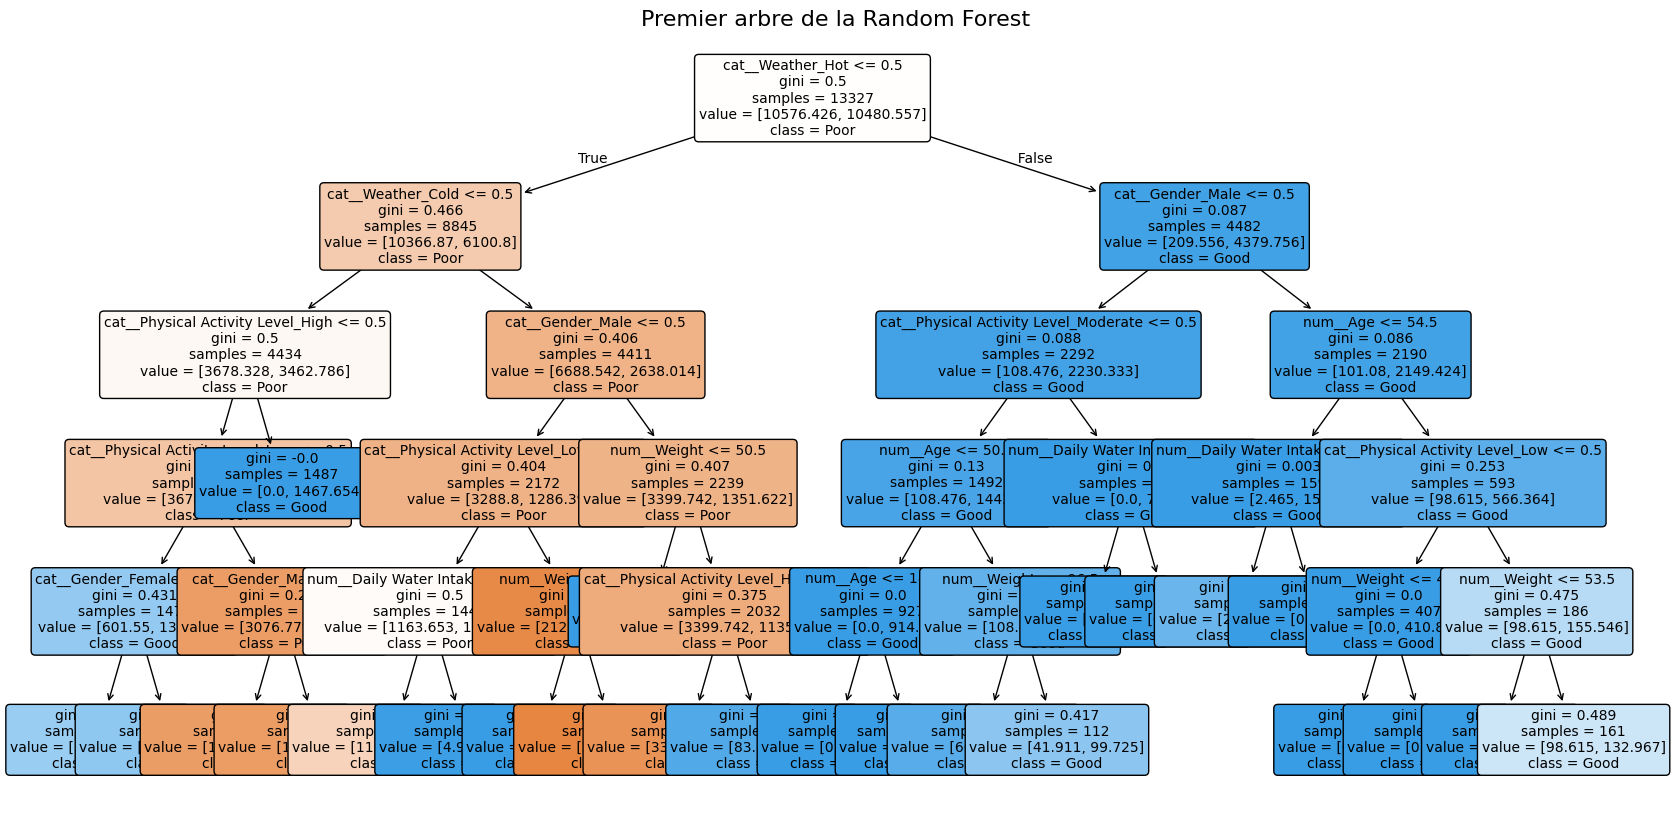

In [96]:
# Visualisation d'un arbre individuel (premier arbre de la forêt)
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(pipeline["model"].estimators_[0], 
          feature_names=feature_names,
          class_names=target_names,
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Premier arbre de la Random Forest", fontsize=16)
plt.show()